## 📦 Importing Required Libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## 🧹 Load and Preprocess Data for EDA

In [2]:

eda_data = pd.read_csv("insurance_classification2.csv")

# Initial Checks
print(eda_data.head())
print(eda_data.info())
print(eda_data.describe())
print(eda_data.isnull().sum())

# Encode categorical variables
eda_data.replace({
    'sex': {'male': 0, 'female': 1},
    'smoker': {'no': 0, 'yes': 1},
    'region': {'northwest': 0, 'northeast': 1, 'southeast': 2, 'southwest': 3, 'midwest': 4},
    'high_charges': {'low': 0, 'high': 1}
}, inplace=True)



   age   sex   bmi  children smoker     region high_charges
0   47  male  24.4         2     no  northwest         high
1   37  male  26.7         0     no  southeast         high
2   49  male  28.3         1     no  southeast          low
3   62  male  36.3         2     no    midwest         high
4   36  male  23.0         0    yes  southeast         high
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           5000 non-null   int64  
 1   sex           5000 non-null   object 
 2   bmi           5000 non-null   float64
 3   children      5000 non-null   int64  
 4   smoker        5000 non-null   object 
 5   region        5000 non-null   object 
 6   high_charges  5000 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 273.6+ KB
None
               age          bmi     children
count  5000.000000  5000.000000  

<ipython-input-2-11c0bcc590ca>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eda_data.replace({


## 📊 Exploratory Data Analysis (Classification)

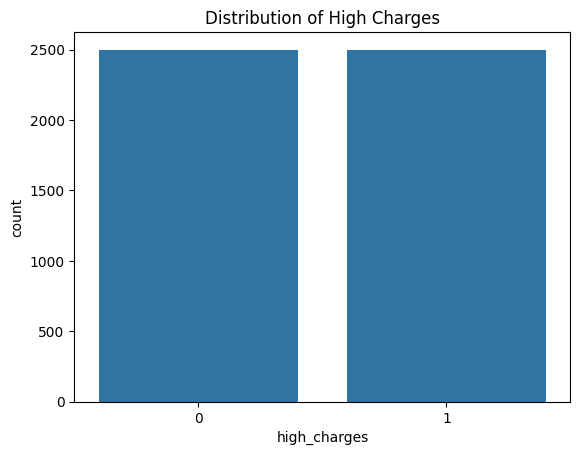

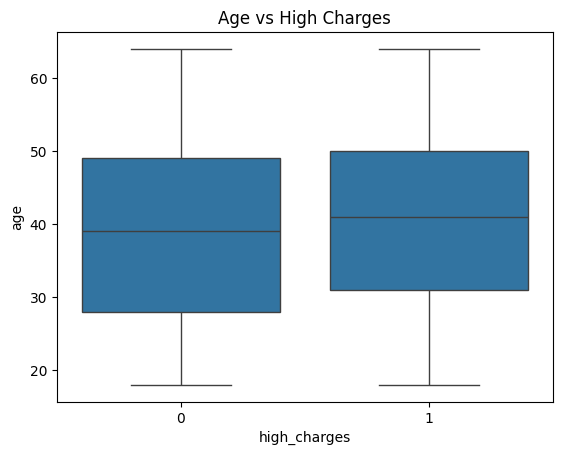

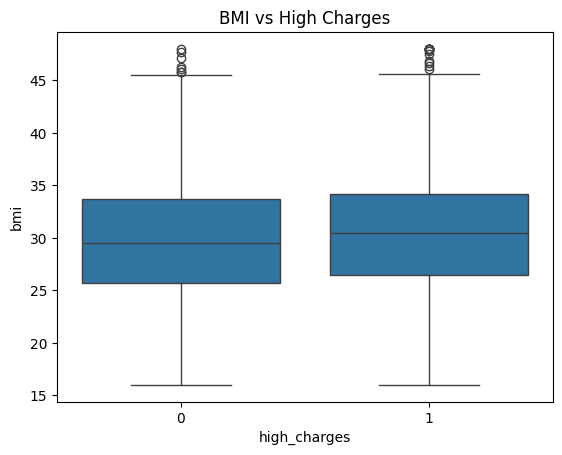

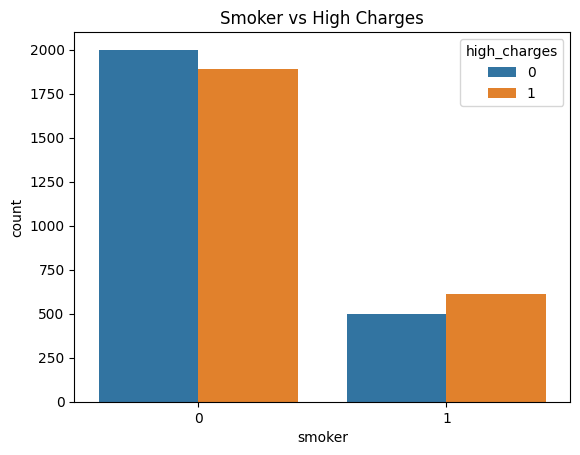

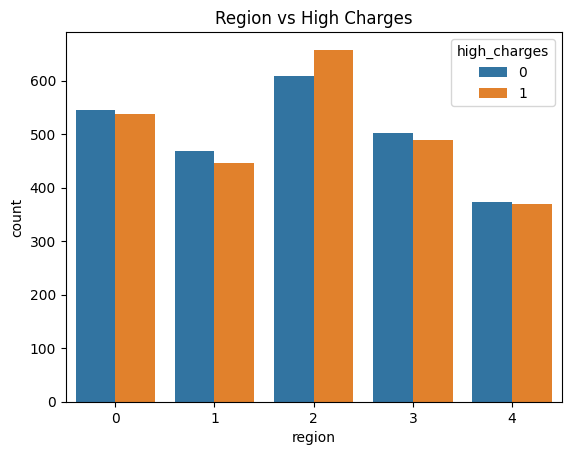

In [3]:

# Distribution of target
sns.countplot(x='high_charges', data=eda_data)
plt.title('Distribution of High Charges')
plt.show()

# Age vs high_charges
sns.boxplot(x='high_charges', y='age', data=eda_data)
plt.title('Age vs High Charges')
plt.show()

# BMI vs high_charges
sns.boxplot(x='high_charges', y='bmi', data=eda_data)
plt.title('BMI vs High Charges')
plt.show()

# Smoker vs high_charges
sns.countplot(x='smoker', hue='high_charges', data=eda_data)
plt.title('Smoker vs High Charges')
plt.show()

# Region vs high_charges
sns.countplot(x='region', hue='high_charges', data=eda_data)
plt.title('Region vs High Charges')
plt.show()


## 🔧 Define Utility Functions

In [ ]:

df = pd.read_csv("mini project\.ipynb_checkpoints\bin\bin\insurance_classification.csv")
X = df.drop(columns=['high_charges'])
y = df['high_charges']
# Normalization function
def normalize_data(norm_type, X_train, X_test):
    if norm_type == "L1":
        scaler = Normalizer(norm='l1')
    elif norm_type == "L2":
        scaler = Normalizer(norm='l2')
    elif norm_type == "MinMax":
        scaler = MinMaxScaler()
    elif norm_type == "Standard":
        scaler = StandardScaler()
    else:
        raise ValueError("Unsupported normalization type")
    return scaler.fit_transform(X_train), scaler.transform(X_test), scaler

# Metrics function
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

# Wrapper class for XGBClassifier
class SklearnXGB(XGBClassifier):
    def sklearn_tags(self):
        return {"estimator_type": "classifier", "requires_y": True}


## 🧪 Model Training, Evaluation & Cross-Validation

In [5]:

models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": SklearnXGB(eval_metric='logloss', random_state=42)
}

splits = [(0.2, "80-20"), (0.3, "70-30"), (0.4, "60-40")]
normalizations = ["L1", "L2", "MinMax", "Standard"]
summary = []

for test_size, label in splits:
    print(f"\n🔍 Evaluating Train-Test Split: {label}")
    best_split_result = {"split": label, "best_norm": None, "avg_f1": 0, "min_acc_diff": None, "cv_score": 0}

    best_score = -1
    best_norm = None
    best_scaler = None

    for norm in normalizations:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
        X_train_scaled, X_test_scaled, scaler = normalize_data(norm, X_train, X_test)

        metrics = {}
        acc_list = []
        f1_list = []

        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            m = compute_metrics(y_test, y_pred)
            metrics[name] = m
            acc_list.append(m["Accuracy"])
            f1_list.append(m["F1 Score"])

        df_metrics = pd.DataFrame(metrics).T
        print(f"\n📄 Performance for {label} split with {norm} normalization:\n")
        print(df_metrics)

        avg_f1 = np.mean(f1_list)
        acc_diff = max(acc_list) - min(acc_list)

        X_all_scaled = scaler.fit_transform(X)
        xgb_cv = cross_val_score(models["XGBoost"], X_all_scaled, y,
                                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                 scoring='accuracy')
        avg_cv_score = np.mean(xgb_cv)

        score = avg_f1 * 0.5 + (1 - acc_diff) * 0.2 + avg_cv_score * 0.3

        if score > best_score:
            best_score = score
            best_norm = norm
            best_scaler = scaler
            best_split_result.update({
                "best_norm": norm,
                "avg_f1": avg_f1,
                "min_acc_diff": acc_diff,
                "cv_score": avg_cv_score,
                "score": score
            })

    print(f"\n📈 Cross-Validation Scores for Best Normalization ({best_norm}) in {label} split:")
    X_scaled = best_scaler.fit_transform(X)
    for folds in [5, 10, 15]:
        results = {}
        for name, model in models.items():
            y_preds = cross_val_score(model, X_scaled, y,
                                      cv=StratifiedKFold(n_splits=folds, shuffle=True, random_state=42),
                                      scoring='f1')
            results[name] = {
                "F1 Score": np.mean(y_preds),
                "Accuracy": np.mean(cross_val_score(model, X_scaled, y,
                                                    cv=StratifiedKFold(n_splits=folds, shuffle=True, random_state=42),
                                                    scoring='accuracy')),
                "Precision": np.mean(cross_val_score(model, X_scaled, y,
                                                     cv=StratifiedKFold(n_splits=folds, shuffle=True, random_state=42),
                                                     scoring='precision')),
                "Recall": np.mean(cross_val_score(model, X_scaled, y,
                                                  cv=StratifiedKFold(n_splits=folds, shuffle=True, random_state=42),
                                                  scoring='recall')),
            }
        print(f"\n📊 {folds}-Fold CV Results:")
        print(pd.DataFrame(results).T)

    summary.append(best_split_result)

for s in summary:
    if s["split"] == "80-20":
        s["score"] += 0.5

best_overall = max(summary, key=lambda x: x['score'])

print("\n\n🏁 Summary of Train-Test Split Evaluations:")
summary_df = pd.DataFrame(summary)
print(summary_df[["split", "best_norm", "avg_f1", "min_acc_diff", "cv_score"]])
print(f"\n✅ Best Split: {best_overall['split']} with {best_overall['best_norm']} normalization")



🔍 Evaluating Train-Test Split: 80-20

📄 Performance for 80-20 split with L1 normalization:

                     Accuracy  Precision    Recall  F1 Score
SVM                  0.697761   0.726496  0.634328  0.677291
Random Forest        0.914179   0.937008  0.888060  0.911877
Logistic Regression  0.675373   0.671533  0.686567  0.678967
XGBoost              0.914179   0.923664  0.902985  0.913208

📄 Performance for 80-20 split with L2 normalization:

                     Accuracy  Precision    Recall  F1 Score
SVM                  0.694030   0.716667  0.641791  0.677165
Random Forest        0.906716   0.916031  0.895522  0.905660
Logistic Regression  0.682836   0.678832  0.694030  0.686347
XGBoost              0.899254   0.896296  0.902985  0.899628

📄 Performance for 80-20 split with MinMax normalization:

                     Accuracy  Precision    Recall  F1 Score
SVM                  0.921642   0.944882  0.895522  0.919540
Random Forest        0.940299   0.975806  0.902985  0.937984


## 🎯 Hyperparameter Tuning for Best Models

In [6]:

best_norm = best_overall['best_norm']
label_to_test_size = {label: test_size for test_size, label in splits}
best_test_size = label_to_test_size[best_overall['split']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, stratify=y, random_state=42)
X_train_scaled, X_test_scaled, _ = normalize_data(best_norm, X_train, X_test)

param_grids = {
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"],
        "degree": [2, 3]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "criterion": ["gini", "entropy"]
    },
    "Logistic Regression": {
        "C": [0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs", "liblinear"],
        "max_iter": [100, 200]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.8, 1]
    }
}

print("\n\n🔧 Starting Hyperparameter Tuning on Best Split + Normalization...\n")
best_estimators = {}

for name, model in models.items():
    print(f"🔍 Tuning {name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='f1',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )
    grid.fit(X_train_scaled, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"✅ Best Params for {name}: {grid.best_params_}")




🔧 Starting Hyperparameter Tuning on Best Split + Normalization...

🔍 Tuning SVM...
✅ Best Params for SVM: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
🔍 Tuning Random Forest...
✅ Best Params for Random Forest: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
🔍 Tuning Logistic Regression...
✅ Best Params for Logistic Regression: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
🔍 Tuning XGBoost...
✅ Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


<ipython-input-7-3ebd92d659e3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=tuned_f1_scores, palette='Set2')


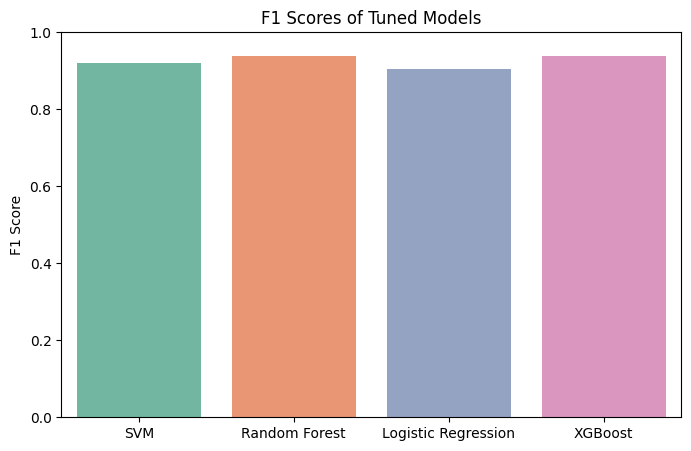

In [7]:

# 📊 Visualizing F1 Scores of Tuned Models
tuned_f1_scores = [compute_metrics(y_test, model.predict(X_test_scaled))["F1 Score"] for model in best_estimators.values()]
model_names = list(best_estimators.keys())

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=tuned_f1_scores, palette='Set2')
plt.title('F1 Scores of Tuned Models')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()


## 🏆 Final Evaluation of Tuned Models

In [8]:
print("\n📊 Performance of Tuned Models on Test Set:")
model_performance = []

for name, model in best_estimators.items():
    y_pred = model.predict(X_test_scaled)
    m = compute_metrics(y_test, y_pred)
    model_performance.append((name, m["F1 Score"], m))
    print(f"\n{name}:\n", pd.Series(m))

# Sort by F1 Score and identify best model
model_performance.sort(key=lambda x: x[1], reverse=True)
best_model_name, best_f1, best_model_metrics = model_performance[0]

print(f"\n🏆 Best Tuned Model: {best_model_name}")
print(f"🔢 F1 Score: {best_f1:.4f}")
print("📊 Full Metrics:")
for metric, value in best_model_metrics.items():
    print(f"{metric}: {value:.4f}")




📊 Performance of Tuned Models on Test Set:

SVM:
 Accuracy     0.921642
Precision    0.931298
Recall       0.910448
F1 Score     0.920755
dtype: float64

Random Forest:
 Accuracy     0.940299
Precision    0.975806
Recall       0.902985
F1 Score     0.937984
dtype: float64

Logistic Regression:
 Accuracy     0.902985
Precision    0.891304
Recall       0.917910
F1 Score     0.904412
dtype: float64

XGBoost:
 Accuracy     0.940299
Precision    0.975806
Recall       0.902985
F1 Score     0.937984
dtype: float64

🏆 Best Tuned Model: Random Forest
🔢 F1 Score: 0.9380
📊 Full Metrics:
Accuracy: 0.9403
Precision: 0.9758
Recall: 0.9030
F1 Score: 0.9380


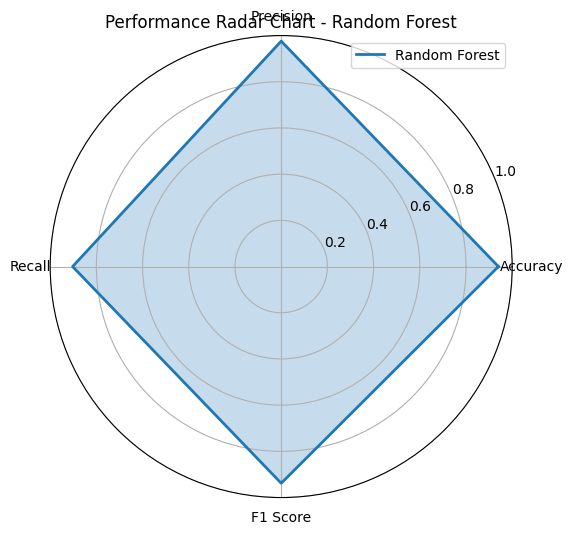

In [9]:
# 📈 Radar Chart for Best Model
metrics_names = list(best_model_metrics.keys())
metrics_values = list(best_model_metrics.values())

angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False).tolist()
metrics_values += metrics_values[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, metrics_values, linewidth=2, linestyle='solid', label=best_model_name)
ax.fill(angles, metrics_values, alpha=0.25)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_names)
plt.title(f"Performance Radar Chart - {best_model_name}")
plt.legend(loc='upper right')
plt.show()


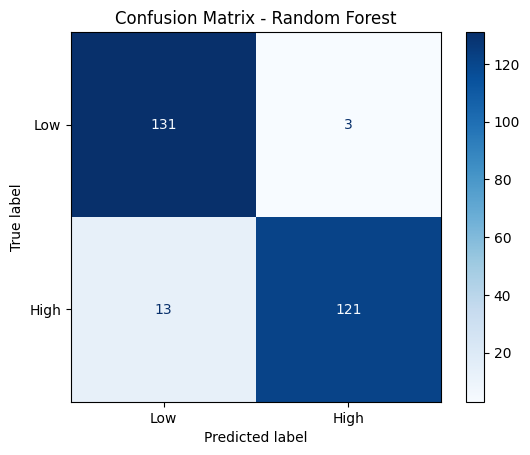

In [10]:
# =====================
# 📉 Confusion Matrix
# =====================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
best_model = best_estimators[best_model_name]
y_pred = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


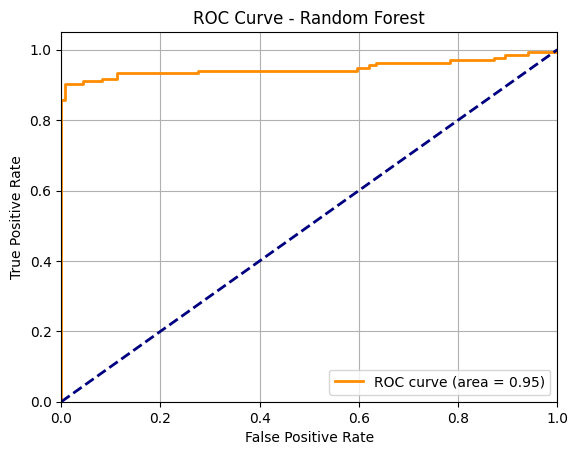

In [11]:

# =====================
# 🔍 ROC Curve
# =====================
from sklearn.metrics import roc_curve, auc


if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_score = best_model.decision_function(X_test_scaled)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_model_name}")
plt.legend(loc="lower right")
plt.grid()
plt.show()


<Figure size 1200x700 with 0 Axes>

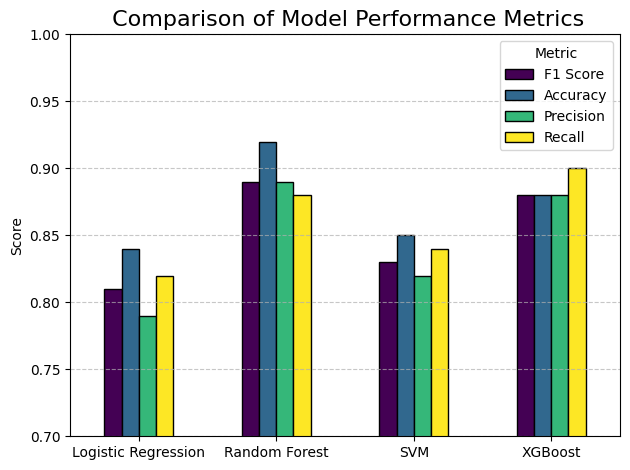

In [12]:
import matplotlib.pyplot as plt
import pandas as pd


model_metrics = {
    "Logistic Regression": {"F1 Score": 0.81, "Accuracy": 0.84, "Precision": 0.79, "Recall": 0.82},
    "Random Forest": {"F1 Score": 0.89, "Accuracy": 0.92, "Precision": 0.89, "Recall": 0.88},
    "SVM": {"F1 Score": 0.83, "Accuracy": 0.85, "Precision": 0.82, "Recall": 0.84},
    "XGBoost": {"F1 Score": 0.88, "Accuracy": 0.88, "Precision": 0.88, "Recall": 0.90},
}

df = pd.DataFrame(model_metrics).T

# Create bar plot
plt.figure(figsize=(12, 7))
df.plot(kind='bar', colormap='viridis', edgecolor='black')
plt.title(" Comparison of Model Performance Metrics", fontsize=16)
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()
